# Inference using pretrained models from huggingface

In [6]:
from datasets import load_dataset

dataset = load_dataset("jxie/flickr8k")

## Example image from Flickr8k dataset

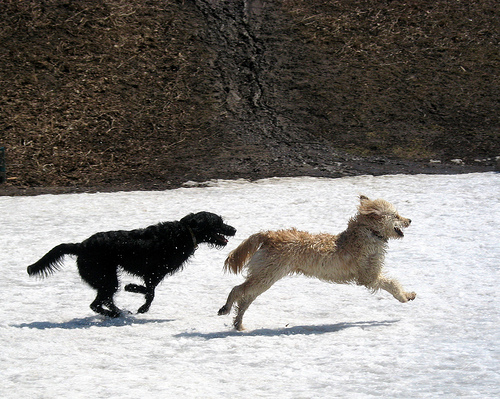

In [7]:
dataset['train']['image'][0]

In [8]:
for i in range(5):
    print(dataset['train'][f'caption_{i}'][0])

A black dog is running after a white dog in the snow .
Black dog chasing brown dog through snow
Two dogs chase each other across the snowy ground .
Two dogs play together in the snow .
Two dogs running through a low lying body of water .


The person who generated the fifth caption has a different interpretation of the picture than the first four captioners, seeing the surface as a low lying body of (frothy?) water, rather than snow. This highlights the subjective nature of image captioning, and the difficulty with establishing a "ground truth".

## Loading pre-trained models

In [9]:
from transformers import pipeline

vit_gpt2 = pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning")
blip_base = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/philipcooper/miniforge3/envs/ml_env2/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## Example of inference from pre-trained models

In [10]:
vit_gpt2(dataset['train']['image'][0])

/Users/philipcooper/miniforge3/envs/ml_env2/lib/python3.9/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'a dog running across a snow covered field '}]

In [11]:
blip_base(dataset['train']['image'][0])

[{'generated_text': 'a dog and a dog running in the snow'}]

## Running inference on test dataset

In [7]:
from transformers.pipelines.pt_utils import KeyDataset

In [8]:
vit_gpt2_predictions = []
blip_base_predictions = []

for image in KeyDataset(dataset['test'], 'image'):
    vit_gpt2_predictions.append(vit_gpt2(image)[0]['generated_text'])
    blip_base_predictions.append(blip_base(image)[0]['generated_text'])

## Evaluate using ROUGE (generated captions vs. reference captions)

In [17]:
import evaluate

rouge = evaluate.load('rouge')

Since we have five captions for each image, we'll evaluate the generated captions against each of the five captions

In [14]:
vit_gpt2_results = []
blip_base_results = []

for i in range(5):
    vit_gpt2_results.append(
        rouge.compute(predictions=vit_gpt2_predictions,
                      references=dataset['test'][f'caption_{i}']))
    blip_base_results.append(
        rouge.compute(predictions=blip_base_predictions,
                      references=dataset['test'][f'caption_{i}']))

In [18]:
import pandas as pd

In [16]:
pd.DataFrame(vit_gpt2_results).mean()

rouge1       0.330371
rouge2       0.098069
rougeL       0.305881
rougeLsum    0.306060
dtype: float64

In [17]:
pd.DataFrame(blip_base_results).mean()

rouge1       0.353489
rouge2       0.124432
rougeL       0.336761
rougeLsum    0.336956
dtype: float64

## Evaluate using CLIP (generated captions vs. reference image)

In [21]:
from torchmetrics.functional.multimodal import clip_score

In [23]:
dataset_torch = dataset.with_format('torch')

Example - we can use the CLIP score to evaluate how well the reference captions correspond to the image.

In [24]:
float(clip_score(dataset_torch['test']['image'][0],
           dataset_torch['test']['caption_4'][0],
           model_name_or_path="openai/clip-vit-base-patch16"))

31.63944435119629

In [21]:
vit_gpt2_clip = []
blip_base_clip = []

for i in range(1000):
    vit_gpt2_clip.append(float(
        clip_score(dataset_torch['test']['image'][i],
                   vit_gpt2_predictions[i],
                   model_name_or_path="openai/clip-vit-base-patch16")))
    blip_base_clip.append(float(
        clip_score(dataset_torch['test']['image'][i],
                   blip_base_predictions[i],
                   model_name_or_path="openai/clip-vit-base-patch16")))

print(pd.Series(vit_gpt2_clip).mean())
print(pd.Series(blip_base_clip).mean())

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 0cfbc59f-a0fc-4e96-b0cf-997102ded267)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch16/resolve/main/config.json
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 79f79705-5d8f-48a9-ad3a-dc2e7a096d4d)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch16/resolve/main/config.json
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: ff7860ac-53a3-4f09-95d2-2a0bbab5f617)')' thrown while requesting HEAD https://huggingface.co/openai/clip-vit-base-patch16/resolve/main/preprocessor_config.json
'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 73ac6eb3-11b6-433e-aee7-94644bf91768)')' throw

28.14976708316803
28.571813968658446


In [50]:
import numpy as np
from tqdm import tqdm

In [54]:
baseline_clip = []

for i in tqdm(range(1000)):
    # select a random caption to CLIP evaluate for each image
    j = np.random.randint(5)
    baseline_clip.append(float(
        clip_score(dataset_torch['test']['image'][i],
                   dataset_torch['test'][f'caption_{j}'][i],
                   model_name_or_path="openai/clip-vit-base-patch16")))

pd.Series(baseline_clip).mean()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [58:22<00:00,  3.50s/it]


32.086649187088014

## Evaluating captions from our models

These captions were generated on the test set in a separate file.

In [13]:
import pickle

with open('captions.pkl', 'rb') as f:
    our_captions = pickle.load(f)

### ROUGE

In [20]:
our_model_rouge = []

for i in range(5):
    our_model_rouge.append(
        rouge.compute(predictions=our_captions,
                      references=dataset['test'][f'caption_{i}']))

pd.DataFrame(our_model_rouge).mean()

rouge1       0.319021
rouge2       0.104758
rougeL       0.299102
rougeLsum    0.298930
dtype: float64

In [26]:
our_model_clip = []

for i in range(1000):
    our_model_clip.append(float(
        clip_score(dataset_torch['test']['image'][i],
                   our_captions[i],
                   model_name_or_path="openai/clip-vit-base-patch16")))

print(pd.Series(our_model_clip).mean())

27.027894116401672
